In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from numba import jit

In [2]:
@jit
def find_closest_centroid(X, centroids):
    m = X.shape[0]
    K = centroids.shape[0]
    idx = np.zeros(m, dtype='int')

    for i in range(m):
        dist = np.zeros(K)
        for j in range(K):
            dist[j] = np.linalg.norm(X[i] - centroids[j])
        idx[i] = np.argmin(dist)

    return idx

In [3]:
@jit
def compute_centroids(X, idx, K):
    m, n = X.shape
    centroids = np.zeros((K, n))
    count = np.zeros(K)
    
    for i, c_i in enumerate(idx):
        centroids[c_i] += X[i]
        count[c_i] += 1

    for i, centroid in enumerate(centroids):
        centroid /= count[i]
        
    return centroids

In [4]:
@jit
def set_initial_centroids(X, K):
    perm_idx = np.random.permutation(X.shape[0])
    centroids = X[perm_idx[:K]]
    return centroids

In [5]:
def run_K_means(X, K, max_iters=10, plot_progress=False):
    m, n = X.shape
    centroids = set_initial_centroids(X, K)
    prev_centroids = centroids
    idx = np.zeros(m)

    if plot_progress:
        fig, ax = plt.subplots()

    for i in tqdm(range(max_iters)):
        idx = find_closest_centroid(X, centroids)
        centroids = compute_centroids(X, idx, K)

        if plot_progress:
            for old, new in zip(prev_centroids, centroids):
                ax.plot([old[0], new[0]], [old[1], new[1]], marker='x', color='black')
        prev_centroids = centroids  

    if plot_progress:
        colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'violet']
        for i in range(idx.shape[0]):
            plt.scatter(X[i, 0], X[i, 1], edgecolors=colors[idx[i]], facecolors='none', s=8)
        plt.grid(False)

    return centroids, idx

In [6]:
image_path = Path('test_bird.png')
original_img = plt.imread(image_path)

In [7]:
p, q, _ = original_img.shape
X_img = original_img.reshape(p * q, 3)

if np.max(X_img) > 1:
    X_img = X_img / 255

In [8]:
# rng = np.random.default_rng()
# # X = rng.integers(0, 100, 100).reshape(-1, 2)
# means = np.array([
#     [0, 0],
#     [75, 125],
#     [100, 50]
# ])
# X = np.vstack([rng.normal(loc=mean, scale=15, size=(500, 2)) for mean in means])

# K = 3
# max_iters = 10

# centroids, idx = run_K_means(X, K, max_iters, plot_progress=True)

In [9]:
K = 32
max_iters = 10
centroids, idx = run_K_means(X_img, K, max_iters, plot_progress=False)

  0%|          | 0/10 [00:00<?, ?it/s]

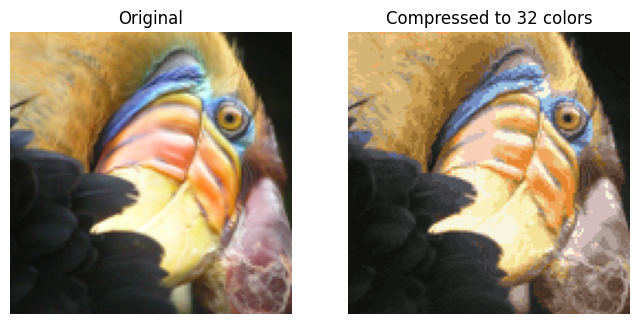

In [10]:
X_compressed = centroids[idx, :] 
X_compressed = X_compressed.reshape(p, q, 3)

fig, ax = plt.subplots(1,2, figsize=(8,8))
plt.axis('off')

ax[0].imshow(original_img)
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(X_compressed)
ax[1].set_title('Compressed to %d colors'%K)
ax[1].set_axis_off()

In [11]:
X_compressed = (X_compressed * 255).astype(np.uint8)
image = Image.fromarray(X_compressed)
image.save(f"compressed_{K}_{image_path}")